# Moving Least Squares and Marching Squares


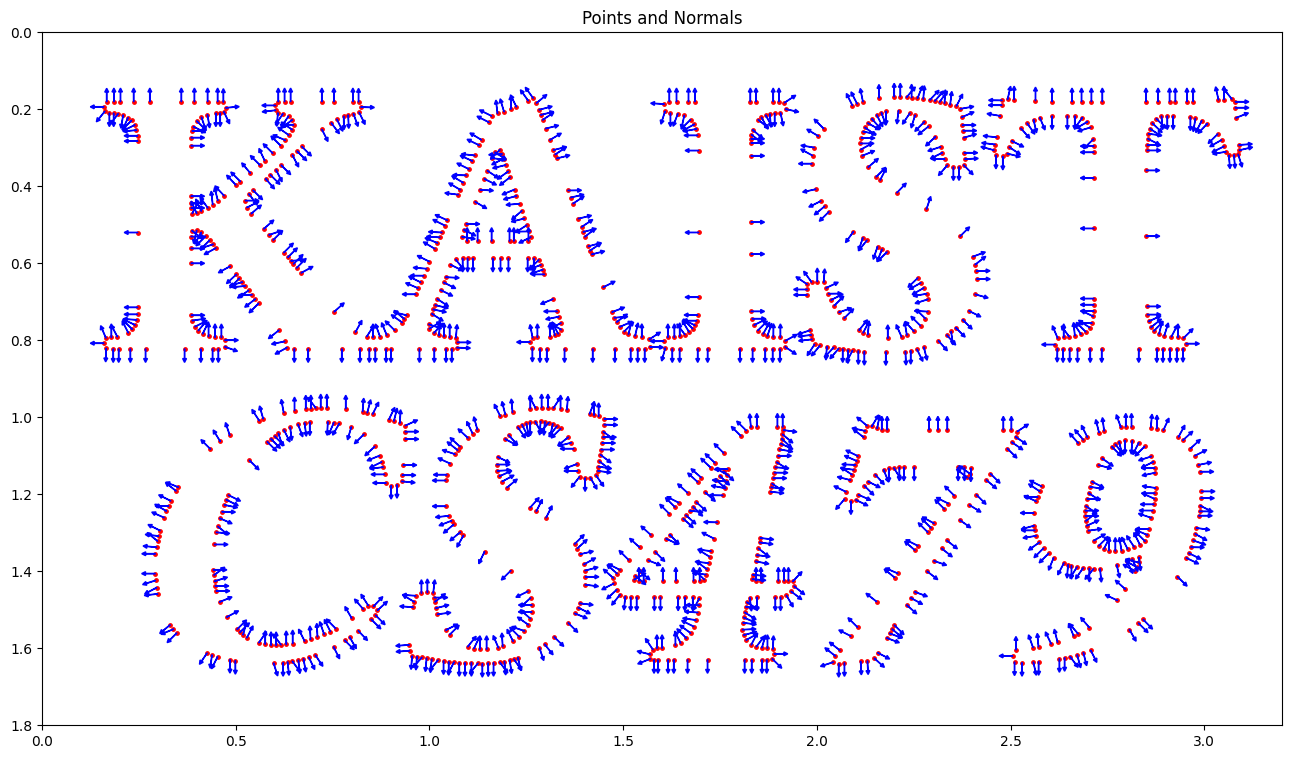

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open("data/input.pkl", "rb") as f:
    points, normals = pickle.load(f)

points, normals = torch.from_numpy(points), torch.from_numpy(normals)

with open("data/gt.pkl", "rb") as f:
    gt_values, gt_contour = pickle.load(f)

gt_values, gt_contour = torch.from_numpy(gt_values), torch.from_numpy(gt_contour)

plt.figure(figsize=(16, 9))
plt.scatter(points[:, 0], points[:, 1], s=6.0, color="r")

for i in range(len(normals)):
    p = points[i]
    n = normals[i] / 40.0  # Scale normal for better visualization
    plt.arrow(p[0], p[1], n[0], n[1], color="b", head_width=0.01, head_length=0.01)

plt.title("Points and Normals")

xlim, ylim = [0.0, 3.2], [0.0, 1.8]

plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().invert_yaxis()
plt.show()

---

# Task 1: Approximation of Implicit Function from a Point Cloud


In this assignment, we use **Implicit Moving Least Squares (IMLS)** to approximate an implicit function $f(\mathbf{x})$ given a set of points $\{\mathbf{p}_i\}$ and their associated normals $\{\mathbf{n}_i\}$. The IMLS method computes $f(\mathbf{x})$ by a **weighted average** of local contributions from each neighbor point:

$$
f(\mathbf{x})
\;=\;
\frac{\displaystyle \sum_{i} w_i \,\bigl(\mathbf{x} - \mathbf{p}_i\bigr)^{T} \,\mathbf{n}_i}
     {\displaystyle \sum_{i} w_i}.
$$

### Weight Function

To capture local influence, each point $\mathbf{p}_i$ contributes a weight $\mathbf{w}_i$. You should use a Gaussian‐like kernel:

$$
w_i
\;=\;
\frac{1}{k_i} \exp\!\Bigl(\!-\tfrac{\|\mathbf{x} - \mathbf{p}_i\|^2}{\epsilon^2}\Bigr),
$$

where

- $\epsilon$ is a _radius_ parameter controlling the falloff of influence (sometimes referred to as the “ball radius”). We use 0.01.
- $k_i$ is the number of neighbor points within $\epsilon$ of $\mathbf{p}_i$.

---


In [3]:
eps = 2e-2

dist = torch.cdist(points, points)

k = torch.sum(dist < eps, dim=1)

In [4]:
def get_f_value(x):
    """
    Input
        x: torch.tensor [#query points, 2(dimension)]
    Output
        f_x: torch.tensor [#query points,]

    Implement the approximation of the Implicit Function
    using Implicit Moving Least Squares method.
    """
    distances = torch.cdist(x, points)  # [N, M]

    weights = (1.0 / k.unsqueeze(0)) * torch.exp(-(distances**2) / (eps**2))  # [N, M]

    diff = x.unsqueeze(1) - points.unsqueeze(0)  # [N, M, 2]

    dot_products = torch.sum(diff * normals.unsqueeze(0), dim=2)  # [N, M]
    numerator = torch.sum(weights * dot_products, dim=1)  # [N]

    denominator = torch.sum(weights, dim=1)  # [N]

    f_x = numerator / denominator

    return f_x

### Visualization of the Implicit Function


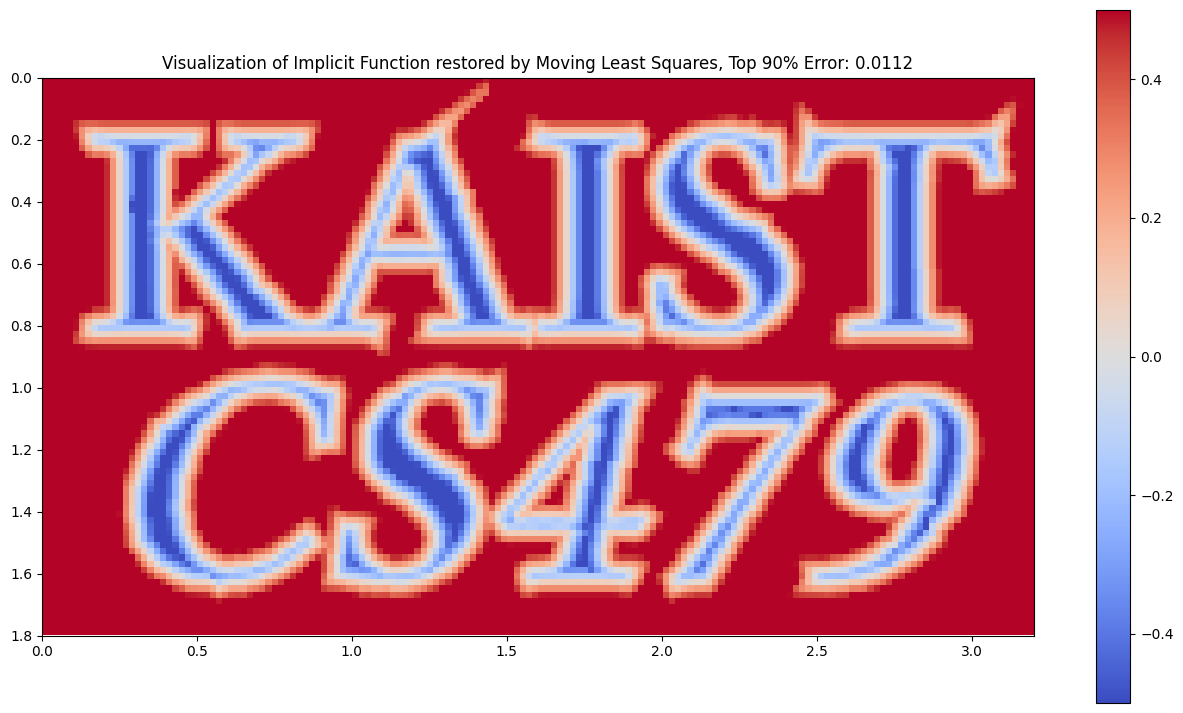

In [5]:
x = np.linspace(*xlim, 160)
y = np.linspace(*ylim, 90)
X, Y = np.meshgrid(x, y)
coord = torch.from_numpy(np.stack((X.reshape(-1), Y.reshape(-1)), axis=1))
Z = get_f_value(coord).reshape(X.shape)
error = torch.sort(torch.abs(gt_values - Z).reshape(-1))[0]
plt.figure(figsize=(16, 9))
plt.imshow(
    torch.clamp(Z * 10.0, -0.5, 0.5),
    extent=[*xlim, *ylim],
    origin="lower",
    cmap="coolwarm",
)
plt.title(
    "Visualization of Implicit Function restored by Moving Least Squares, Top 90% Error: {:.4f}".format(
        error[int(error.shape[0] * 0.9)]
    )
)
plt.colorbar()
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().invert_yaxis()
plt.show();

---

# Task 2: Marching Squares


**Marching Squares** is a **2D** algorithm to extract a contour (or iso‐curve) from a scalar field $F(\mathbf{x})$. It is the 2D analogue of the well‐known **Marching Cubes** algorithm in 3D.

1. **Grid the Domain**

   - You overlay a uniform grid over the bounding box that contains your data.
   - At each grid cell corner \((i, j)\), you evaluate \(F(i, j)\).

2. **Cell Classification**

   - For each cell (which has 4 corners), you check if each corner’s value is above or below the iso‐level (often \(F = 0\)).
   - This gives you a pattern of bits (e.g., 0 for below, 1 for above), which indicates which edges of the cell the contour will cross.

3. **Edge Interpolation**

   - If two corners differ in sign, the contour must pass somewhere between them.
   - You compute the intersection point by linearly interpolating along the edge:

     $$
     \mathbf{p} \;=\; \mathbf{p}_1 \;+\; \alpha\,(\mathbf{p}_2 - \mathbf{p}_1),
     \quad \text{where} \quad
     \alpha \;=\; \frac{\,0 - F(\mathbf{p}_1)\,}{F(\mathbf{p}_2) \;-\; F(\mathbf{p}_1)}.
     $$

4. **Connecting Segments**

   - Based on which edges are intersected, you connect the intersection points within each cell to form small line segments.
   - These line segments across all cells piece together to form continuous contours.
   - Special **ambiguous cases** (where a cell’s corners give four intersections) require disambiguation rules so that the lines connect consistently.

5. **Outcome**
   - The final result is a collection of line segments or polylines forming the approximate curve $F(\mathbf{x})= 0$.
   - Marching Squares is **straightforward**, **efficient**, and widely used in scientific visualization and image processing.

---


In [6]:
points_to_offset = torch.tensor(
    [
        [0, 0],  # location of point 0    of cell at (y, x): (y, x) + (0, 0)
        [0, 1],  # location of point 1    of cell at (y, x): (y, x) + (0, 1)
        [1, 1],  # location of point 2    of cell at (y, x): (y, x) + (1, 1)
        [1, 0],  # location of point 3    of cell at (y, x): (y, x) + (1, 0)
    ],
    dtype=torch.int64,
)

edge_to_points = torch.tensor(
    [
        [0, 1],  # edge 0:  point 0 and point 1
        [1, 2],  # edge 1:  point 1 and point 2
        [2, 3],  # edge 2:  point 2 and point 3
        [3, 0],  # edge 3:  point 3 and point 0
    ],
    dtype=torch.int64,
)

case_to_edges = torch.tensor(
    [
        [[-1, -1], [-1, -1]],  # case 0   0000 - no contour
        [[0, 3], [-1, -1]],  # case 1   1000 - corner at point 0
        [[0, 1], [-1, -1]],  # case 2   0100 - corner at point 1
        [[1, 3], [-1, -1]],  # case 3   1100 - edge along top
        [[1, 2], [-1, -1]],  # case 4   0010 - corner at point 2
        [[0, 1], [2, 3]],  # case 5   1010 - saddle case (two segments)
        [[0, 2], [-1, -1]],  # case 6   0110 - edge along right
        [[2, 3], [-1, -1]],  # case 7   1110 - corner cut at point 3
        [[2, 3], [-1, -1]],  # case 8   0001 - corner at point 3
        [[0, 2], [-1, -1]],  # case 9   1001 - edge along left
        [[0, 3], [1, 2]],  # case 10  0101 - saddle case (two segments)
        [[1, 2], [-1, -1]],  # case 11  1101 - corner cut at point 2
        [[1, 3], [-1, -1]],  # case 12  0011 - edge along bottom
        [[0, 1], [-1, -1]],  # case 13  1011 - corner cut at point 1
        [[0, 3], [-1, -1]],  # case 14  0111 - corner cut at point 0
        [[-1, -1], [-1, -1]],  # case 15  1111 - no contour
    ],
    dtype=torch.int64,
)

In [7]:
def marching_squares(data, level=0.0):
    Ny, Nx = data.shape
    # sdf value for (y, x): data[y, x]
    grid_index = torch.arange(Ny * Nx).reshape(Ny, Nx)
    cell_index = grid_index[:-1, :-1]  # Ny-1 x Nx-1
    cell_coord = torch.stack((cell_index // Nx, cell_index % Nx), dim=2)
    cell_cases = torch.zeros_like(cell_index)  # Ny-1 x Nx-1
    for case, offset in zip([1, 2, 4, 8], points_to_offset):
        cell_case = (
            data[cell_coord[..., 0] + offset[0], cell_coord[..., 1] + offset[1]] > level
        ).to(cell_index.dtype)
        cell_cases += case * cell_case

    contour = []
    for edgei in range(2):
        edges = case_to_edges[cell_cases, edgei]  # Ny-1 x Nx-1 x 2
        exist = edges[..., 0] != -1  # Ny-1 x Nx-1
        edges = edges[exist]  # B x 2
        cell_crd = cell_coord[exist].view(-1, 1, 1, 2)  # B x 1 x 1 x 2
        coords_ = points_to_offset[edge_to_points[edges]] + cell_crd  # B x 2 x 2 x 2
        values_ = data[coords_[..., 0], coords_[..., 1]]  # B x 2 x 2

        ts_ = (level - values_[..., 0]) / (values_[..., 1] - values_[..., 0])  # B x 2
        ts_ = torch.clamp(ts_.unsqueeze(2), 0.0, 1.0)  # B x 2 x 1
        points_ = coords_[:, :, 0] + ts_ * (
            coords_[:, :, 1] - coords_[:, :, 0]
        )  # B x 2 x 2
        points_ = torch.flip(points_, [-1])
        scale = torch.tensor([[[(xlim[1] - xlim[0]) / Nx, (ylim[1] - ylim[0]) / Ny]]])
        start = torch.tensor([[[xlim[0], ylim[0]]]])
        contour.append(start + points_ * scale)

    contour = torch.cat(contour, dim=0)
    return contour


contours = marching_squares(Z);

### Visualization of the Contour

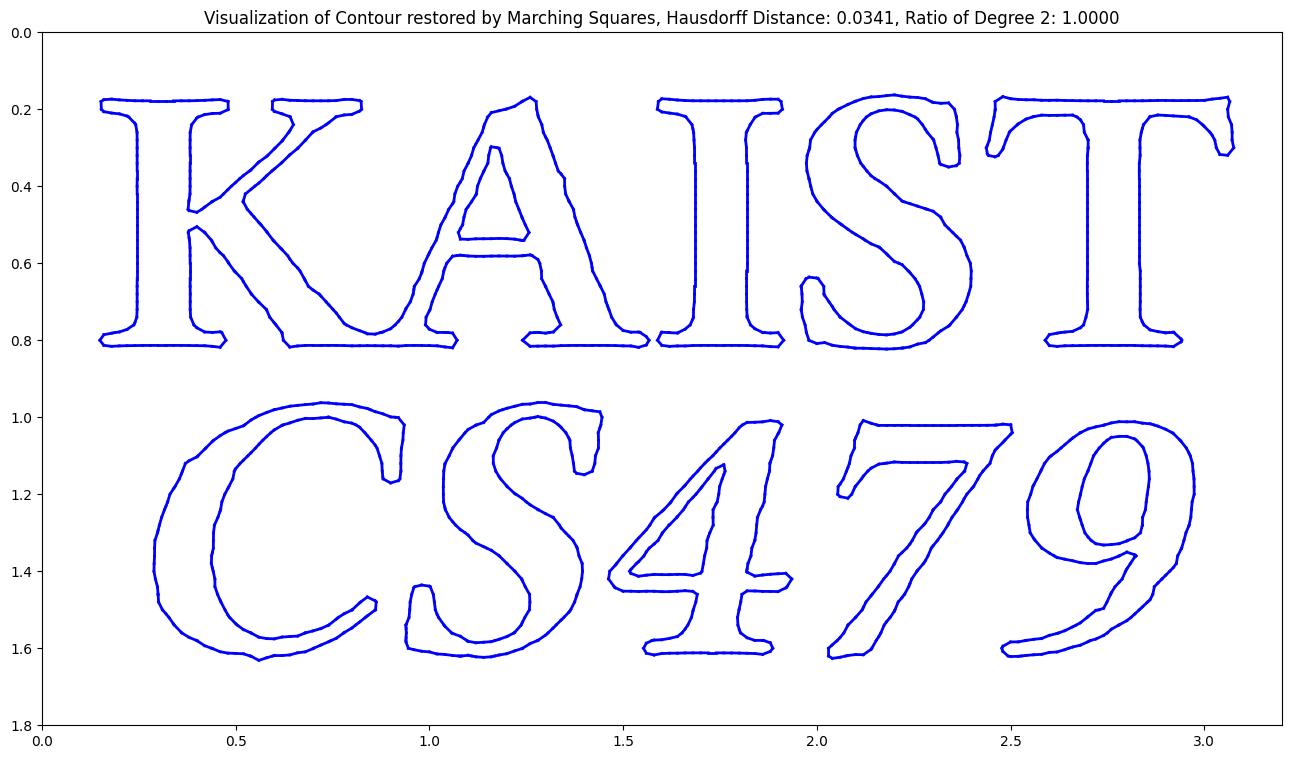

In [8]:
def point_to_segment_distance(points, seg_start, seg_end):
    seg_vec = seg_end - seg_start  # [M, D]
    seg_len_sq = torch.sum(seg_vec**2, dim=-1, keepdim=True)  # [M, 1]

    p_vec = points[:, None, :] - seg_start[None, :, :]  # [N, M, D]
    proj = torch.sum(p_vec * seg_vec, dim=-1, keepdim=True) / seg_len_sq  # [N, M, 1]
    proj = torch.clamp(proj, 0, 1)  # Clamp to segment [0, 1]

    closest_points = seg_start[None, :, :] + proj * seg_vec[None, :, :]  # [N, M, D]
    dists = torch.norm(points[:, None, :] - closest_points, dim=-1)  # [N, M]
    return dists


def hausdorff_distance(set1, set2):
    start1, end1 = set1[:, 0, :], set1[:, 1, :]  # [N, D]
    start2, end2 = set2[:, 0, :], set2[:, 1, :]  # [M, D]

    min_d1 = torch.min(
        torch.minimum(
            point_to_segment_distance(start1, start2, end2),
            point_to_segment_distance(end1, start2, end2),
        ),
        dim=1,
    )[0]  # Min for each row [N]
    min_d2 = torch.min(
        torch.minimum(
            point_to_segment_distance(start2, start1, end1),
            point_to_segment_distance(end2, start1, end1),
        ),
        dim=1,
    )[0]  # Min for each row [M]

    directed_H1 = torch.max(min_d1)  # A -> B
    directed_H2 = torch.max(min_d2)  # B -> A
    return torch.max(directed_H1, directed_H2).item()


def degree2_ratio(contours):
    contour_ = contours.clone()
    contour_ = (contours * 10000000).to(torch.int32)
    verts_unq = list(set([tuple(x.numpy().tolist()) for x in contour_.view(-1, 2)]))
    verts_idx = {vert: i for i, vert in enumerate(verts_unq)}
    V = len(verts_unq)
    degree = torch.zeros((V,), dtype=torch.int32)
    for vert0, vert1 in contour_:
        idx0 = verts_idx[tuple(vert0.numpy().tolist())]
        idx1 = verts_idx[tuple(vert1.numpy().tolist())]
        degree[idx0] += 1
        degree[idx1] += 1
    return torch.sum(degree == 2).item() / V


plt.figure(figsize=(16, 9))
for (x1, y1), (x2, y2) in contours:
    plt.plot([x1, x2], [y1, y2], "b-", linewidth=2)
plt.title(
    "Visualization of Contour restored by Marching Squares, Hausdorff Distance: {:.4f}, Ratio of Degree 2: {:.4f}".format(
        hausdorff_distance(contours, gt_contour), degree2_ratio(contours)
    )
)
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().invert_yaxis()
plt.show();